IMPORTANT NOTES:

This tutorial is only for google colab environment.

It is recommended to work with GPU for this tutorial. To enable GPU on google colab, see following for more information https://stackoverflow.com/questions/50560395/how-to-install-cuda-in-google-colab-gpus/60338745#60338745
 
For this tutorial, you need to download data from this link https://www.kaggle.com/dansbecker/cityscapes-image-pairs and then, upload data to google drive (to folder 'Colab Notebooks' for example).

In [1]:
# add necessary toolbox

import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm.notebook import tqdm

In [2]:
# add google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# load and visualize data

In [3]:
data_dir = os.path.join("/content/gdrive/MyDrive/Colab Notebooks/input", "cityscapes_data")
train_dir = os.path.join(data_dir, "train") 
val_dir = os.path.join(data_dir, "val")
train_list = os.listdir(train_dir)
val_list = os.listdir(val_dir)
print(len(train_list), len(val_list))

2975 500


/content/gdrive/MyDrive/Colab Notebooks/input/cityscapes_data/train/2778.jpg


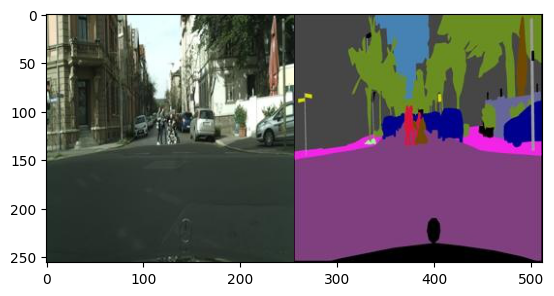

In [4]:
# visualize one sample of training data (which includes both input and output)

sample_image_file_path = os.path.join(train_dir, train_list[0])
sample_image = Image.open(sample_image_file_path).convert("RGB")
plt.imshow(sample_image)
print(sample_image_file_path)

In [5]:
# sample data is the concatenation of input [256x256x3] and output [256x256x3] (3 is for RGB)

np.array( sample_image ).shape

(256, 512, 3)

In [6]:
# helper function to split the image and label
def split_image(image):
    image = np.array(image)
    cityscape, label = image[:, :256, :], image[:, 256:, :]
    return cityscape, label

(256, 512, 3)
0 255 0 255


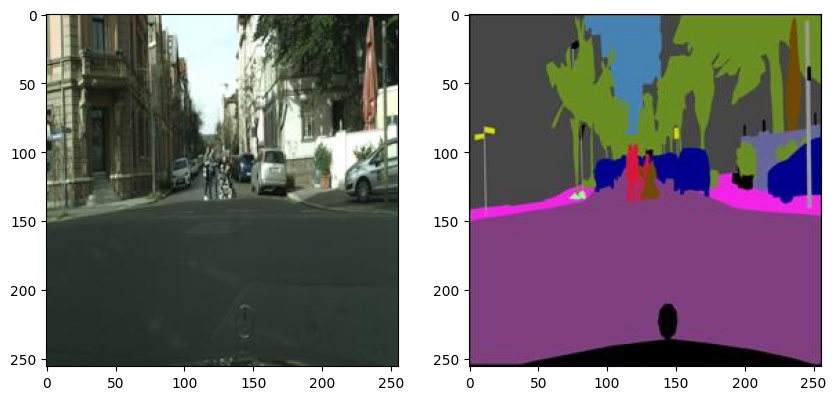

In [7]:
sample_image = np.array(sample_image)
print(sample_image.shape)

cityscape, label = split_image(sample_image)
print(cityscape.min(), cityscape.max(), label.min(), label.max())

cityscape, label = Image.fromarray(cityscape), Image.fromarray(label)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(cityscape)
axes[1].imshow(label)

In [8]:
# define labels

num_items = 1000
color_array = np.random.choice(range(256), 3*num_items).reshape(num_items, 3)
print(color_array.shape)
print(color_array[:5, :])

(1000, 3)
[[ 33 108 238]
 [254 189 167]
 [ 82 104 250]
 [171 214  10]
 [ 46  17 114]]


In [9]:
# create a function to reduce [256 x 256 x 3] labels of values from 0 -> 255 to [256 x 256] label class of values from 0 -> 9

num_classes = 10
label_model = KMeans(n_clusters=num_classes)
label_model.fit(color_array)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=10)

Text(0.5, 1.0, 'label class')

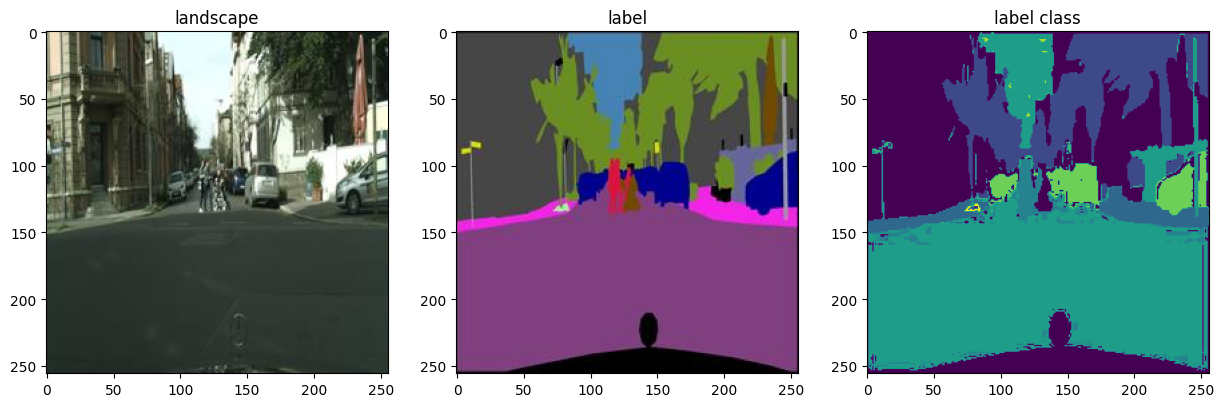

In [10]:
cityscape, label = split_image(sample_image)
label_class = label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(cityscape)
axes[0].set_title("landscape")
axes[1].imshow(label)
axes[1].set_title("label")
axes[2].imshow(label_class)
axes[2].set_title("label class")

In [11]:
class CityscapeDataset(Dataset):
    
    def __init__(self, image_dir, label_model):
        self.image_dir = image_dir
        self.image_fns = os.listdir(image_dir)
        self.label_model = label_model
        
    def __len__(self):
        return len(self.image_fns)
    
    def __getitem__(self, index):
        image_fn = self.image_fns[index]
        image_fp = os.path.join(self.image_dir, image_fn)
        image = Image.open(image_fp).convert('RGB')
        image = np.array(image)
        cityscape, label = self.split_image(image)
        label_class = self.label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
        cityscape = self.transform(cityscape)
        label_class = torch.Tensor(label_class).long()
        return cityscape, label_class
    
    def split_image(self, image):
        image = np.array(image)
        cityscape, label = image[:, :256, :], image[:, 256:, :]
        return cityscape, label
    
    def transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)    

In [12]:
dataset = CityscapeDataset(train_dir, label_model)
print(len(dataset))

2975


In [13]:
cityscape, label_class = dataset[0]
print(cityscape.shape, label_class.shape)

torch.Size([3, 256, 256]) torch.Size([256, 256])


# UNET architecture

the standard U-net (as described in the article https://arxiv.org/pdf/1505.04597.pdf) is as below:

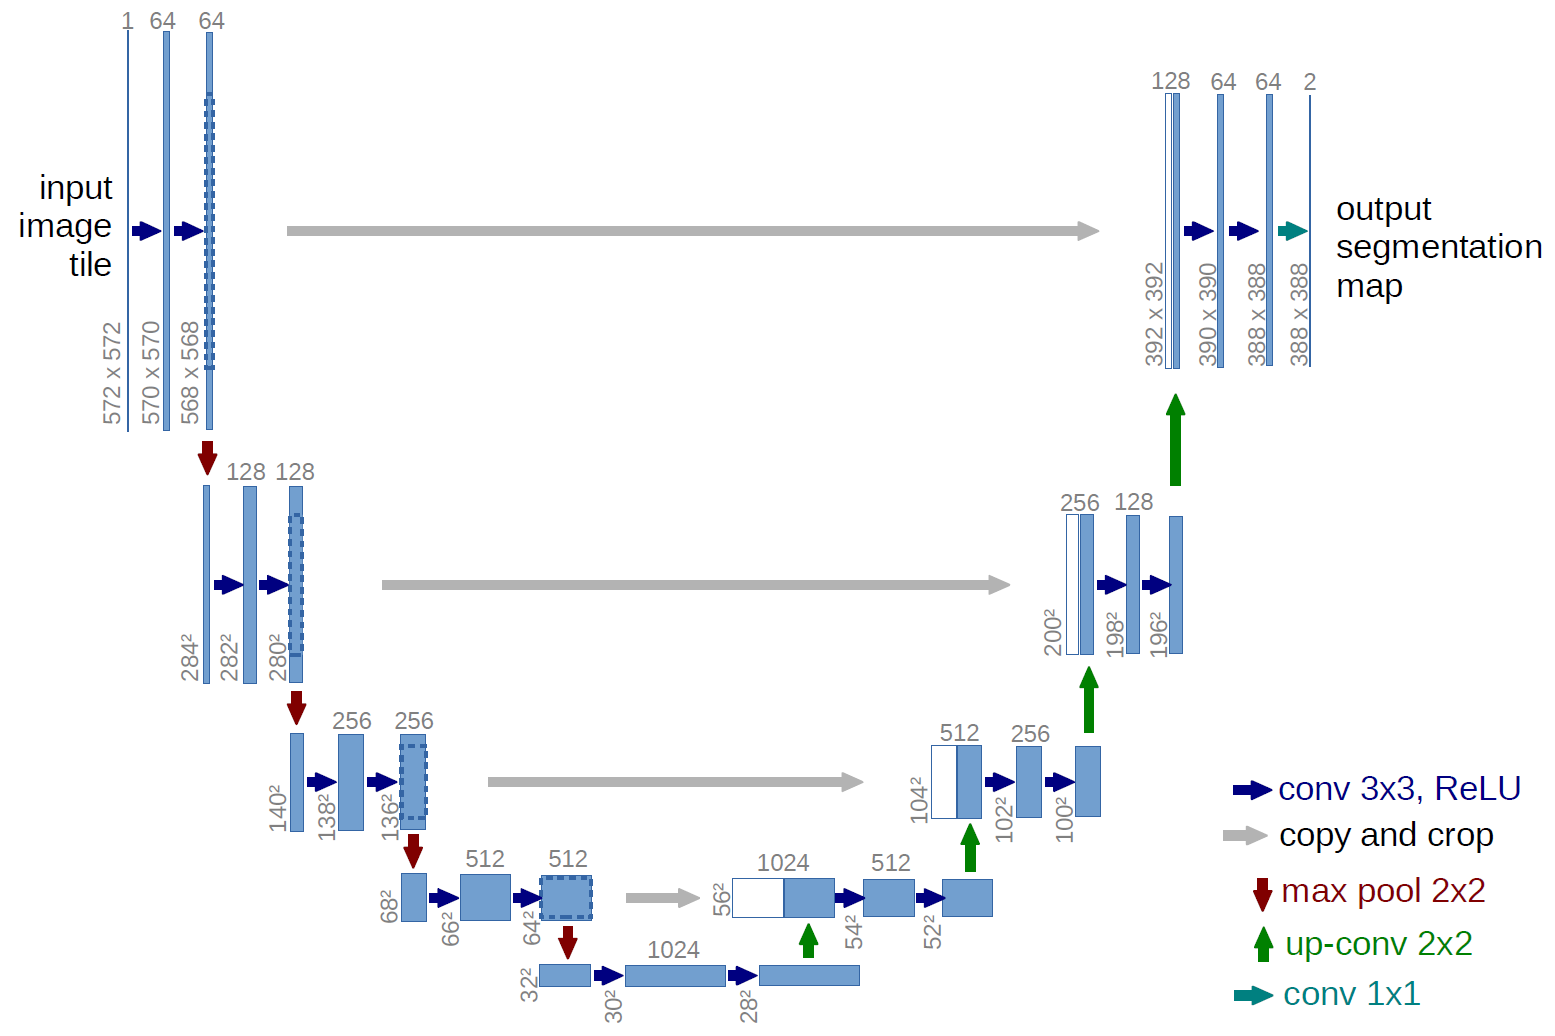

In [14]:
class double_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class down_layer(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down_layer, self).__init__()
        self.pool = nn.MaxPool2d(2, stride=2, padding=0)
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(self.pool(x))
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up, self).__init__()
        self.up_scale = nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2)

    def forward(self, x1, x2): # x1 (bs,out_ch,w1,h1) x2 (bs,in_ch,w2,h2)
        x2 = self.up_scale(x2) # (bs,out_ch,2*w2,2*h2)
        diffY = x1.size()[2] - x2.size()[2]
        diffX = x1.size()[3] - x2.size()[3]

        x2 = F.pad(x2, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2]) # (bs,out_ch,w1,h1)
        x = torch.cat([x2, x1], dim=1) # (bs,2*out_ch,w1,h1)
        return x

class up_layer(nn.Module):
    def __init__(self, in_ch, out_ch): # !! 2*out_ch = in_ch !!
        super(up_layer, self).__init__()
        self.up = up(in_ch, out_ch)
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2): # x1 (bs,out_ch,w1,h1) x2 (bs,in_ch,w2,h2)
        a = self.up(x1, x2) # (bs,2*out_ch,w1,h1)
        x = self.conv(a) # (bs,out_ch,w1,h1) because 2*out_ch = in_ch
        return x

class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        in_channels = 3
        out_channels = num_classes
        self.num_classes = num_classes
        self.conv1 = double_conv(in_channels, 64)
        self.down1 = down_layer(64, 128)
        self.down2 = down_layer(128, 256)
        self.down3 = down_layer(256, 512)
        self.down4 = down_layer(512, 1024)
        self.up1 = up_layer(1024, 512)
        self.up2 = up_layer(512, 256)
        self.up3 = up_layer(256, 128)
        self.up4 = up_layer(128, 64)
        self.last_conv = nn.Conv2d(64, out_channels, 1)

    def forward(self, x): # (bs,in_channels,w,d)
        x1 = self.conv1(x) # (bs,64,w,d)
        x2 = self.down1(x1) # (bs,128,w/2,d/2)
        x3 = self.down2(x2) # (bs,256,w/4,d/4)
        x4 = self.down3(x3) # (bs,512,w/8,h/8)
        x5 = self.down4(x4) # (bs,1024,w/16,h/16)
        x1_up = self.up1(x4, x5) # (bs,512,w/8,h/8)
        x2_up = self.up2(x3, x1_up) # (bs,256,w/4,h/4)
        x3_up = self.up3(x2, x2_up) # (bs,128,w/2,h/2)
        x4_up = self.up4(x1, x3_up) # (bs,64,w,h)
        output = self.last_conv(x4_up) # (bs,out_channels,w,h)
        return output

In [15]:
model = UNet(num_classes=num_classes)

# train model

In [16]:
# train model

batch_size = 20

epochs = 10
lr = 0.01

dataset = CityscapeDataset(train_dir, label_model)
data_loader = DataLoader(dataset, batch_size=batch_size)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = UNet(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

step_losses = []
epoch_losses = []
for epoch in tqdm(range(epochs)):
    epoch_loss = 0
    for X, Y in tqdm(data_loader, total=len(data_loader), leave=False):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        Y_pred = model(X)
        loss = criterion(Y_pred, Y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        step_losses.append(loss.item())
    epoch_losses.append(epoch_loss/len(data_loader))   

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

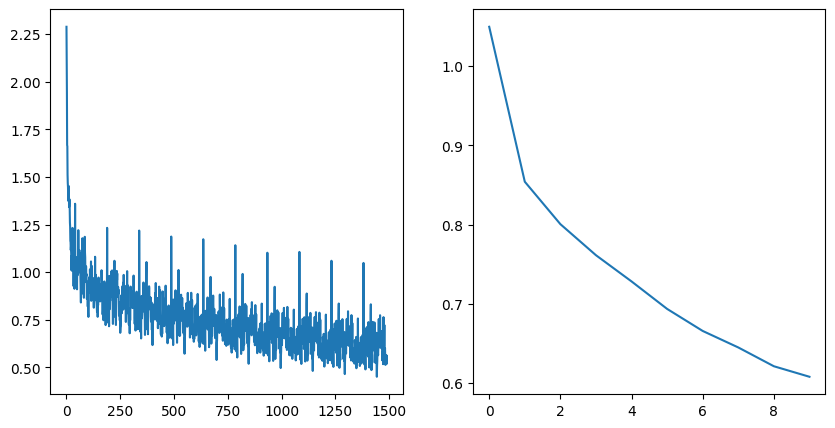

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(step_losses)
axes[1].plot(epoch_losses)

In [18]:
test_batch_size = 8
dataset = CityscapeDataset(val_dir, label_model)
data_loader = DataLoader(dataset, batch_size=test_batch_size)

In [19]:
X, Y = next(iter(data_loader))
X, Y = X.to(device), Y.to(device)
Y_pred = model(X)
print(Y_pred.shape)
Y_pred = torch.argmax(Y_pred, dim=1)
print(Y_pred.shape)

torch.Size([8, 10, 256, 256])
torch.Size([8, 256, 256])


In [20]:
# inverse transform to scale centered images to [0 1] range (for plotting)
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

for i in range(test_batch_size):
    
    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    
    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")

Output hidden; open in https://colab.research.google.com to view.